## 7. Mech Interp

A significant amount of code here was borrowed from the excellent [ARENA course](https://arena-chapter1-transformer-interp.streamlit.app/) on transformers and mechanistic interpretability

In [1]:
# from huggingface_hub import hf_hub_download, notebook_login
# notebook_login()

In [2]:
# !pip install "torch>=2.1.0" einops datasets jaxtyping "sae_lens==3.23.1" openai tabulate "nbformat>=4.2.0" umap-learn hdbscan eindex-callum git+https://github.com/callummcdougall/CircuitsVis.git#subdirectory=python git+https://github.com/callummcdougall/sae_vis.git@callum/v3 "transformer-lens>=2.7.0"

### 7.1 Imports 

In [3]:
from IPython.display import HTML, IFrame, clear_output, display
import random
from rich import print as rprint
from rich.table import Table
from tqdm.auto import tqdm
from functools import partial
import torch as t
import torch.nn.functional as F
from torch import Tensor, nn
from jaxtyping import Float, Int
import einops
import pandas as pd
import json

import matplotlib.pyplot as plt
import numpy as np

device = t.device(
    "mps"
    if t.backends.mps.is_available()
    else "cuda" if t.cuda.is_available() else "cpu"
)

from sae_lens.toolkit.pretrained_saes_directory import get_pretrained_saes_directory
from sae_lens import (
    SAE,
    ActivationsStore,
    HookedSAETransformer,
    LanguageModelSAERunnerConfig,
    SAEConfig,
    SAETrainingRunner,
    upload_saes_to_huggingface,
)

from transformer_lens import ActivationCache, HookedTransformer, utils
from transformer_lens.hook_points import HookPoint
from tabulate import tabulate

import pickle, glob

### 7.2 Load up model and Sparse Autoencoder

In [4]:
gemmascope_sae_release = "gemma-scope-2b-pt-mlp-canonical"
gemmascope_sae_id = "layer_20/width_16k/canonical"

gemma_2_2b = HookedSAETransformer.from_pretrained("gemma-2-2b", device=device)
gemma_2_2b_sae = SAE.from_pretrained(
    gemmascope_sae_release, gemmascope_sae_id, device=str(device)
)[0]

# Option to use Instruction tuned version of model:
# gemma_2_2b = HookedSAETransformer.from_pretrained("gemma-2-2b-it", device=device)

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

Loaded pretrained model gemma-2-2b into HookedTransformer


### 7.3 Test Model with Prompt from Chapter

In [5]:
prompt = "The reliability of Wikipedia is very"
answer = " high"

In [6]:
utils.test_prompt(prompt, answer, gemma_2_2b)

Tokenized prompt: ['<bos>', 'The', ' reliability', ' of', ' Wikipedia', ' is', ' very']
Tokenized answer: [' high']


Performance on answer token:
Rank: 2        Logit: 25.30 Prob: 11.16% Token: | high|

Top 0th token. Logit: 25.89 Prob: 20.21% Token: | important|
Top 1th token. Logit: 25.41 Prob: 12.50% Token: | much|
Top 2th token. Logit: 25.30 Prob: 11.16% Token: | high|
Top 3th token. Logit: 25.27 Prob: 10.80% Token: | low|
Top 4th token. Logit: 25.14 Prob:  9.48% Token: | questionable|
Top 5th token. Logit: 24.59 Prob:  5.47% Token: | poor|
Top 6th token. Logit: 24.40 Prob:  4.55% Token: | good|
Top 7th token. Logit: 23.56 Prob:  1.96% Token: | well|
Top 8th token. Logit: 23.51 Prob:  1.87% Token: | controversial|
Top 9th token. Logit: 23.24 Prob:  1.42% Token: | often|


Ranks of the answer tokens: [(' high', 2)]

In [7]:
# Manually compute top next tokens
tokens = gemma_2_2b.to_tokens(prompt)
logits, cache = gemma_2_2b.run_with_cache(tokens, remove_batch_dim=True)

probs = logits[:, -1, :].softmax(dim=-1)
token_probs, token_ids = probs[-1, :].topk(10, dim=-1)
for tk, p in zip(token_ids, token_probs):
    print(gemma_2_2b.to_string(tk.item()), round(p.item(), 4))

 important 0.2021
 much 0.125
 high 0.1116
 low 0.108
 questionable 0.0948
 poor 0.0547
 good 0.0455
 well 0.0196
 controversial 0.0187
 often 0.0142


### 7.4 Longer Generation

In [8]:
prompt_2 = "The reliability of Wikipedia is very important"

In [9]:
GENERATE_KWARGS = dict(temperature=0.5, freq_penalty=2.0, verbose=False)
gemma_2_2b.generate(prompt_2, max_new_tokens=50, **GENERATE_KWARGS)

'The reliability of Wikipedia is very important to the success of your online business. If you are running an online business, you need a reliable website that will help you to achieve your goals. You can use Wikipedia for this purpose. It’s a great way to get information about different topics'

In [10]:
GENERATE_KWARGS = dict(temperature=0.5, freq_penalty=2.0, verbose=False)
gemma_2_2b.generate(prompt_2, max_new_tokens=50, **GENERATE_KWARGS)

'The reliability of Wikipedia is very important for the credibility of the site. The community has a lot of power to influence its development and direction, but there are also many people who want to use Wikipedia as a tool for vandalism or other malicious activities. In order to protect against these threats,'

### 7.5 Visualize Data Moving Through model

In [11]:
prompt = "The reliability of Wikipedia is very"

In [12]:
tokens = gemma_2_2b.to_tokens(prompt)
logits, cache = gemma_2_2b.run_with_cache(tokens, remove_batch_dim=True)

In [13]:
cache["hook_embed"].shape

torch.Size([7, 2304])

In [14]:
m = cache["hook_embed"].detach().cpu().numpy()[-1, :].reshape(48, 48)

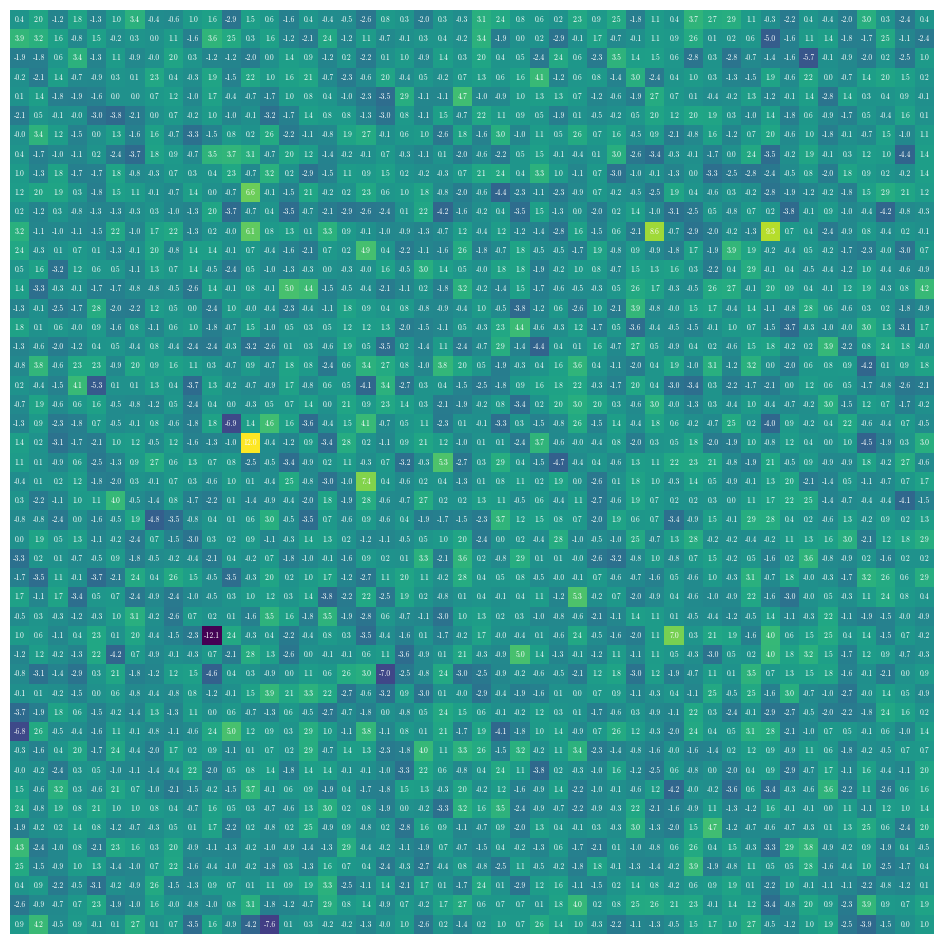

In [15]:
fig = plt.figure(0, (12, 12))
ax = fig.add_subplot(111)
plt.imshow(m)
# plt.colorbar();

for i in range(m.shape[0]):
    for j in range(m.shape[1]):
        ax.text(
            j,
            i,
            f"{m[i, j]:.1f}",
            ha="center",
            va="center",
            color="white",
            fontsize=5.5,
            fontname="cmr10",
        )
plt.axis("off");

(-0.5, 47.5, 47.5, -0.5)

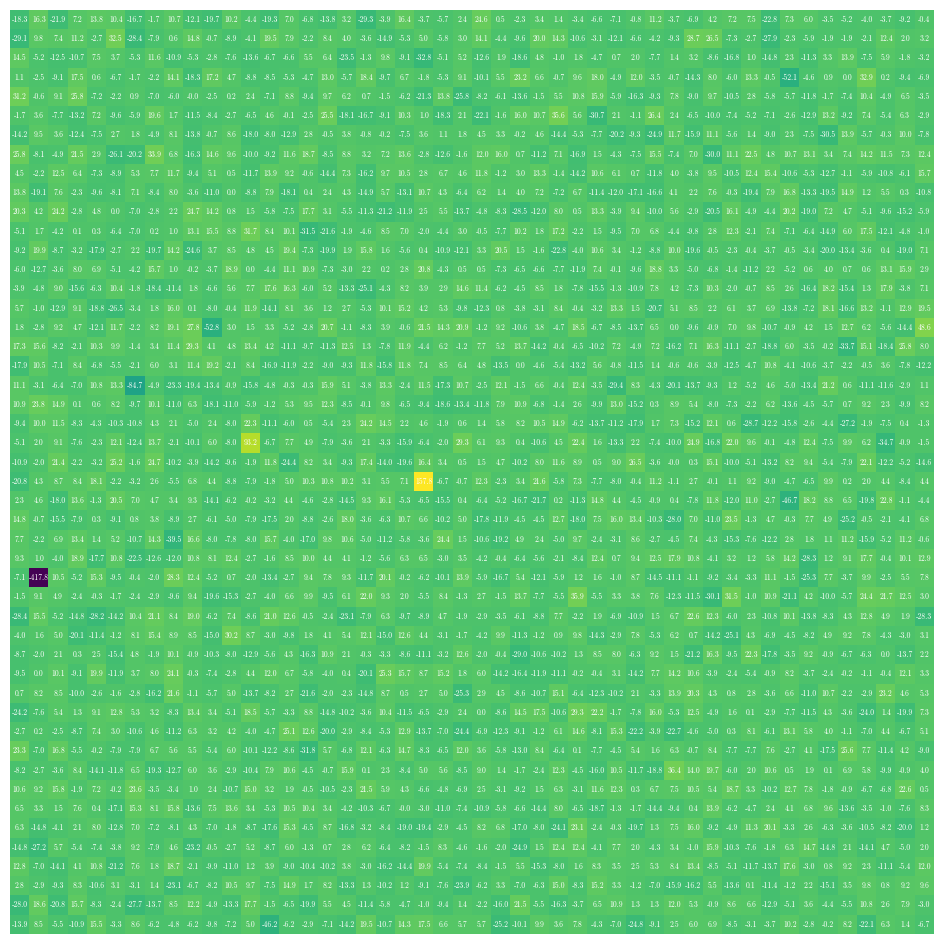

In [16]:
# Final outputs
m = cache["blocks.25.hook_resid_post"].detach().cpu().numpy()[-1, :].reshape(48, 48)

fig = plt.figure(0, (12, 12))
ax = fig.add_subplot(111)
plt.imshow(m)
# plt.colorbar()

for i in range(m.shape[0]):
    for j in range(m.shape[1]):
        ax.text(
            j,
            i,
            f"{m[i, j]:.1f}",
            ha="center",
            va="center",
            color="white",
            fontsize=5.5,
            fontname="cmr10",
        )
plt.axis("off")

### 7.6 Intermediate Model Predictions

In [17]:
# Before the first transformer block
activations_norm_ln_final = gemma_2_2b.ln_final(cache["hook_embed"])
my_logits = gemma_2_2b.unembed(activations_norm_ln_final)
my_logits_softcap = gemma_2_2b.cfg.output_logits_soft_cap * F.tanh(
    my_logits / gemma_2_2b.cfg.output_logits_soft_cap
)

probs = my_logits_softcap.softmax(dim=-1)
token_probs, token_ids = probs[-1, :].topk(10, dim=-1)
for tk, p in zip(token_ids, token_probs):
    print(gemma_2_2b.to_string(tk.item()), round(p.item(), 4))

 very 0.006
very 0.006
 Very 0.006
Very 0.006
 VERY 0.006
 très 0.006
 muy 0.006
VERY 0.006
 extremely 0.006
 sehr 0.0059


In [18]:
tokens = gemma_2_2b.to_tokens(prompt)
logits, cache = gemma_2_2b.run_with_cache(tokens, remove_batch_dim=True)
all_res = []

for layer_id in range(25):
    activations_norm_next_layer = cache[
        "blocks." + str(layer_id + 1) + ".ln1.hook_normalized"
    ]

    my_logits = gemma_2_2b.unembed(activations_norm_next_layer)
    my_logits_softcap = gemma_2_2b.cfg.output_logits_soft_cap * F.tanh(
        my_logits / gemma_2_2b.cfg.output_logits_soft_cap
    )

    probs = my_logits_softcap.softmax(dim=-1)
    token_probs, token_ids = probs[-1, :].topk(10, dim=-1)
    res = {}
    for tk, p in zip(token_ids, token_probs):
        res[gemma_2_2b.to_string(tk.item())] = round(p.item(), 4)
    all_res.append(res)


# Final outputs
probs = logits.softmax(dim=-1)
token_probs, token_ids = probs[0, -1, :].topk(10, dim=-1)
res = {}
for tk, p in zip(token_ids, token_probs):
    res[gemma_2_2b.to_string(tk.item())] = round(p.item(), 4)
all_res.append(res)

keys_data = []
for d in all_res:
    row = [f'"{key}"' for key in d.keys()]
    keys_data.append(row)

values_data = []
for d in all_res:
    row = list(d.values())
    values_data.append(row)

max_cols = max(len(row) for row in keys_data)
keys_df = pd.DataFrame(keys_data, columns=[f"Token_{i+1}" for i in range(max_cols)])
values_df = pd.DataFrame(values_data, columns=[f"Prob_{i+1}" for i in range(max_cols)])

In [19]:
keys_df  # Top tokens as we move through the model

,Token_1,Token_2,Token_3,Token_4,Token_5,Token_6,Token_7,Token_8,Token_9,Token_10
0,""" very""","""very""","""Very""",""" Very""",""" VERY""","""VERY""",""" très""",""" muy""",""" sehr""",""" extremely"""
1,""" very""","""very""","""Very""",""" Very""",""" VERY""","""VERY""",""" muy""",""" très""",""" sehr""",""" очень"""
2,""" very""","""Very""","""very""",""" Very""",""" VERY""","""VERY""",""" très""",""" muy""",""" sehr""",""" extremely"""
3,""" very""","""Very""","""very""",""" Very""",""" VERY""","""VERY""",""" très""",""" muy""",""" sehr""",""" quite"""
4,""" very""","""Very""",""" Very""","""very""",""" VERY""","""VERY""",""" très""",""" muy""",""" sehr""","""Очень"""
5,"""<bos>""",""" very""","""Very""",""" Very""","""very""",""" VERY""","""VERY""",""" really""",""" muy""",""" quite"""
6,""" very""","""Very""",""" Very""","""very""",""" VERY""","""VERY""",""" really""",""" much""",""" extremely""",""" muy"""
7,""" very""",""" Very""","""Very""",""" VERY""","""very""","""VERY""",""" extremely""",""" highly""",""" much""",""" really"""
8,""" very""","""very""",""" Very""","""Very""",""" VERY""",""" really""",""" extremely""",""" much""",""" highly""","""VERY"""
9,""" very""","""Very""",""" Very""","""very""",""" VERY""","""VERY""",""" really""",""" well""",""" extremely""",""" highly"""


In [20]:
values_df  # Top token probabilities as we move through the model

,Prob_1,Prob_2,Prob_3,Prob_4,Prob_5,Prob_6,Prob_7,Prob_8,Prob_9,Prob_10
0,0.0161,0.0161,0.0161,0.0161,0.0160,0.0159,0.0158,0.0158,0.0154,0.0151
1,0.0254,0.0253,0.0253,0.0252,0.0249,0.0245,0.0240,0.0239,0.0225,0.0212
2,0.0309,0.0300,0.0299,0.0299,0.0291,0.0280,0.0250,0.0246,0.0239,0.0217
3,0.0976,0.0802,0.0779,0.0750,0.0687,0.0575,0.0404,0.0400,0.0326,0.0292
4,0.1365,0.0968,0.0898,0.0870,0.0842,0.0643,0.0301,0.0285,0.0241,0.0232
5,0.3661,0.3139,0.0688,0.0613,0.0611,0.0406,0.0227,0.0098,0.0085,0.0077
6,0.5737,0.1024,0.1001,0.0661,0.0492,0.0242,0.0095,0.0092,0.0087,0.0063
7,0.8468,0.0389,0.0273,0.0207,0.0192,0.0090,0.0074,0.0072,0.0062,0.0043
8,0.8304,0.0343,0.0332,0.0266,0.0138,0.0120,0.0097,0.0074,0.0070,0.0066
9,0.8752,0.0277,0.0262,0.0241,0.0094,0.0057,0.0056,0.0056,0.0049,0.0039


### 7.7 Steering on a Neuron

In [21]:
neuron_index = 1393

In [22]:
def scale_hook(value, hook):
    # value[:, :, neuron_index] = -160 #Null cass/pass through/sanity check
    return value


logits = gemma_2_2b.run_with_hooks(
    tokens, fwd_hooks=[("blocks.20.hook_mlp_out", scale_hook)]
)
probs = logits[:, -1, :].softmax(dim=-1)
token_probs, token_ids = probs[-1, :].topk(10, dim=-1)
for tk, p in zip(token_ids, token_probs):
    print(gemma_2_2b.to_string(tk.item()), round(p.item(), 4))

 important 0.2021
 much 0.125
 high 0.1116
 low 0.108
 questionable 0.0948
 poor 0.0547
 good 0.0455
 well 0.0196
 controversial 0.0187
 often 0.0142


In [23]:
def scale_hook(value, hook):
    value[:, :, neuron_index] = -160  # Clamp to large negative value
    return value


logits = gemma_2_2b.run_with_hooks(
    tokens, fwd_hooks=[("blocks.20.hook_mlp_out", scale_hook)]
)
probs = logits[:, -1, :].softmax(dim=-1)
token_probs, token_ids = probs[-1, :].topk(10, dim=-1)
for tk, p in zip(token_ids, token_probs):
    print(gemma_2_2b.to_string(tk.item()), round(p.item(), 4))

 important 0.2263
 high 0.125
 much 0.1136
 low 0.0902
 questionable 0.0757
 good 0.0572
 poor 0.0366
 well 0.0226
 controversial 0.0196
 often 0.0138


In [24]:
def scale_hook(value, hook):
    value[:, :, neuron_index] = 160  # Clamp to large positive value
    return value


logits = gemma_2_2b.run_with_hooks(
    tokens, fwd_hooks=[("blocks.20.hook_mlp_out", scale_hook)]
)
probs = logits[:, -1, :].softmax(dim=-1)
token_probs, token_ids = probs[-1, :].topk(10, dim=-1)
for tk, p in zip(token_ids, token_probs):
    print(gemma_2_2b.to_string(tk.item()), round(p.item(), 4))

 much 0.1862
 important 0.151
 low 0.1136
 questionable 0.1066
 poor 0.0887
 high 0.0692
 good 0.0299
 often 0.0186
 well 0.0165
 dependent 0.0142


### 7.8 Sparse Autoencoder

In [25]:
def display_dashboard(
    sae_release="gpt2-small-res-jb",
    sae_id="blocks.7.hook_resid_pre",
    latent_idx=0,
    width=1200,
    height=800,
):
    release = get_pretrained_saes_directory()[sae_release]
    neuronpedia_id = release.neuronpedia_id[sae_id]
    url = (
        f"https://neuronpedia.org/{neuronpedia_id}/{latent_idx}"
        f"?embed=true&embedexplanation=true&embedplots=true"
        f"&embedtest=true&height=300"
    )
    print(url)
    display(IFrame(url, width=width, height=height))


def steering_hook(
    activations: Float[Tensor, "batch pos d_in"],
    hook: HookPoint,
    sae: SAE,
    latent_idx: int,
    steering_coefficient: float,
) -> Tensor:
    """
    Steers the model by returning a modified activations tensor, with some
    multiple of the steering vector added to allsequence positions.
    """
    return activations + steering_coefficient * sae.W_dec[latent_idx]


def generate_with_steering(
    model: HookedSAETransformer,
    sae: SAE,
    prompt: str,
    latent_idx: int,
    steering_coefficient: float = 1.0,
    max_new_tokens: int = 50,
):
    """
    Generates text with steering. A multiple of the steering vector
    (the decoder weight for this latent) is added to
    the last sequence position before every forward pass.
    """
    _steering_hook = partial(
        steering_hook,
        sae=sae,
        latent_idx=latent_idx,
        steering_coefficient=steering_coefficient,
    )

    with model.hooks(fwd_hooks=[(sae.cfg.hook_name, _steering_hook)]):
        output = model.generate(
            prompt, max_new_tokens=max_new_tokens, **GENERATE_KWARGS
        )

    return output

In [26]:
# Get top activations on final token
_, cache = gemma_2_2b.run_with_cache_with_saes(
    prompt,
    saes=[gemma_2_2b_sae],
    stop_at_layer=gemma_2_2b_sae.cfg.hook_layer + 1,
)
sae_acts_post = cache[f"{gemma_2_2b_sae.cfg.hook_name}.hook_sae_acts_post"]
sae_acts_post = sae_acts_post[0, -1, :].detach().cpu().numpy()

In [27]:
sae_acts_post.shape

(16384,)

In [28]:
top_indices = np.argsort(np.abs(sae_acts_post))[-10:][::-1]
sae_acts_post[top_indices]

array([45.9957  , 37.256424, 30.383385, 23.406425, 19.714025, 18.762693,
       17.087051, 15.014446, 14.42557 , 13.609097], dtype=float32)

In [29]:
top_indices  # Top activating features

array([ 7344,  8353,  8249, 16286, 13821, 11987, 11622, 11279, 14440,
        3827])

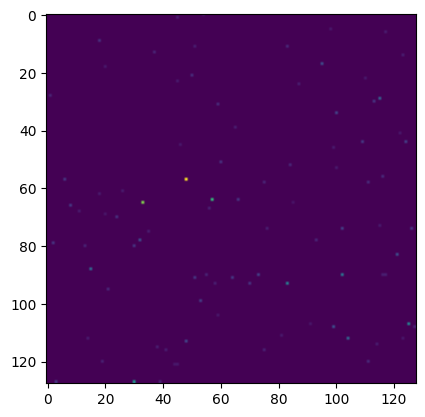

In [30]:
plt.imshow(sae_acts_post.reshape(128, 128))

In [31]:
display_dashboard(
    sae_release=gemmascope_sae_release, sae_id=gemmascope_sae_id, latent_idx=8249
)

https://neuronpedia.org/gemma-2-2b/20-gemmascope-mlp-16k/8249?embed=true&embedexplanation=true&embedplots=true&embedtest=true&height=300


### 7.9 Sparse Autoencoder Steering

In [32]:
GENERATE_KWARGS = dict(temperature=0.5, freq_penalty=2.0, verbose=False)

In [33]:
# Test our prompt, to see what the model says
with gemma_2_2b.saes(saes=[gemma_2_2b_sae]):
    utils.test_prompt(prompt, answer, gemma_2_2b)

Tokenized prompt: ['<bos>', 'The', ' reliability', ' of', ' Wikipedia', ' is', ' very']
Tokenized answer: [' high']


Performance on answer token:
Rank: 2        Logit: 25.49 Prob: 12.46% Token: | high|

Top 0th token. Logit: 25.84 Prob: 17.56% Token: | important|
Top 1th token. Logit: 25.57 Prob: 13.51% Token: | much|
Top 2th token. Logit: 25.49 Prob: 12.46% Token: | high|
Top 3th token. Logit: 25.27 Prob: 10.01% Token: | low|
Top 4th token. Logit: 25.27 Prob:  9.98% Token: | questionable|
Top 5th token. Logit: 24.45 Prob:  4.41% Token: | poor|
Top 6th token. Logit: 24.39 Prob:  4.12% Token: | good|
Top 7th token. Logit: 23.68 Prob:  2.02% Token: | controversial|
Top 8th token. Logit: 23.57 Prob:  1.82% Token: | well|
Top 9th token. Logit: 23.27 Prob:  1.35% Token: | dependent|


Ranks of the answer tokens: [(' high', 2)]

In [34]:
latent_idx = 8249
_steering_hook = partial(
    steering_hook,
    sae=gemma_2_2b_sae,
    latent_idx=latent_idx,
    steering_coefficient=100,
)

with gemma_2_2b.hooks(fwd_hooks=[(gemma_2_2b_sae.cfg.hook_name, _steering_hook)]):
    utils.test_prompt(prompt, answer, gemma_2_2b)

Tokenized prompt: ['<bos>', 'The', ' reliability', ' of', ' Wikipedia', ' is', ' very']
Tokenized answer: [' high']


Performance on answer token:
Rank: 4        Logit: 23.42 Prob:  4.76% Token: | high|

Top 0th token. Logit: 24.88 Prob: 20.61% Token: | much|
Top 1th token. Logit: 24.80 Prob: 19.01% Token: | important|
Top 2th token. Logit: 24.77 Prob: 18.35% Token: | questionable|
Top 3th token. Logit: 23.44 Prob:  4.88% Token: | low|
Top 4th token. Logit: 23.42 Prob:  4.76% Token: | high|
Top 5th token. Logit: 22.82 Prob:  2.61% Token: | controversial|
Top 6th token. Logit: 22.75 Prob:  2.44% Token: | poor|
Top 7th token. Logit: 22.46 Prob:  1.83% Token: | good|
Top 8th token. Logit: 22.42 Prob:  1.76% Token: | often|
Top 9th token. Logit: 22.29 Prob:  1.54% Token: | debatable|


Ranks of the answer tokens: [(' high', 4)]

In [35]:
_steering_hook = partial(
    steering_hook,
    sae=gemma_2_2b_sae,
    latent_idx=latent_idx,
    steering_coefficient=500,
)

with gemma_2_2b.hooks(fwd_hooks=[(gemma_2_2b_sae.cfg.hook_name, _steering_hook)]):
    utils.test_prompt(prompt, answer, gemma_2_2b)

Tokenized prompt: ['<bos>', 'The', ' reliability', ' of', ' Wikipedia', ' is', ' very']
Tokenized answer: [' high']


Performance on answer token:
Rank: 40       Logit: 16.76 Prob:  0.02% Token: | high|

Top 0th token. Logit: 24.68 Prob: 60.81% Token: | question|
Top 1th token. Logit: 23.35 Prob: 16.01% Token: | questioned|
Top 2th token. Logit: 22.87 Prob:  9.97% Token: | into|
Top 3th token. Logit: 21.96 Prob:  3.99% Token: | questionable|
Top 4th token. Logit: 21.06 Prob:  1.63% Token: | Question|
Top 5th token. Logit: 20.72 Prob:  1.16% Token: | open|
Top 6th token. Logit: 20.71 Prob:  1.15% Token: | disputed|
Top 7th token. Logit: 19.83 Prob:  0.47% Token: | serious|
Top 8th token. Logit: 19.81 Prob:  0.47% Token: | much|
Top 9th token. Logit: 19.78 Prob:  0.45% Token: | debatable|


Ranks of the answer tokens: [(' high', 40)]

In [36]:
# Longer generation with steering
generate_with_steering(
    gemma_2_2b, gemma_2_2b_sae, prompt, latent_idx, steering_coefficient=100.0
)

'The reliability of Wikipedia is very questionable. I\'ve seen many questions which were answered by people who didn\'t know what they were talking about.\n\nA question that was asked on the wiki: "How do you make a question mark?"\n\nThere are 3 ways to'